<a href="https://colab.research.google.com/github/1722101709/Internship/blob/feedback_protocol_with_16-bit-data/feedback_protocol_with_16_bit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import gym
from collections import deque
import random

In [22]:
n = 16 # no of bits

In [9]:
class OUNoise(object): # noise class
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self): # resetting the state
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self): # exploring the next state
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0): # get action for the current state
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


        
# memory class to store the experiences
class Memory:
    def __init__(self, max_size): # initializing memory with max_size
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done): # push method to add experience into the memory
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size): # seperating the elements in the experience into  seperate lists
        state_batch = [] # states
        action_batch = [] # actions
        reward_batch = [] # rewards
        next_state_batch = [] # next state
        done_batch = [] # is_done

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self): # to get the size of the memory filled with experiences
        return len(self.buffer)

In [10]:
# importing necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module): # critic class to implement the critic network 
    
    def __init__(self, input_size, hidden_size, output_size): # initializing the critic network
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action): # forward propogation i.e., input to the input layer => output from the output layer

        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module): # Actor class to implement the Actor Network

    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4): # initializing the Actor network
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state): # forward propogation in Actor network with input

        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [11]:
# importing necessary modules 
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn


class DDPGagent: # agent class(Deep Deterministic Policy Gradient)

    # initilaizations
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Parameters
        self.num_states = env.observation_space.shape[0] # number of states
        self.num_actions = env.action_space.shape[0] # no of actions
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions) # actor network
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions) # actor target network
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions) # critic network
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions) # critic target network

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size) # initialize the memory  
        self.critic_criterion  = nn.MSELoss() # loss function
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate) # optimizers for actor network
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate) # optimizers for critic network
    
    def get_action(self, state): # to get the action for the state by passing state as input to the actor network
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size): # updating the sampling after batch_size iterations
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad() # actor network
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad() # critic network
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

In [12]:
# importing modules
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
# Environment
class Environment(Env):

    def __init__(self): # initializing environment
        self.action_space = Box(low = np.array([-1]), high = np.array([1]), dtype=float)
        self.observation_space = Box(low = np.array([-1]), high = np.array([1]), dtype=float)
        self.state = np.round(np.random.random(1), decimals=2)
        self.n = 2**n
        self.data = self.get_data(self.n)
        self.iter = 0
    def step(self, action): # taking actions on environment

        reward = abs(action)
        done, next_state = True if self.iter  == self.n-2 else  False, np.array([self.data[self.iter+1]])
        self.state = next_state
        self.iter += 1
        return self.state,reward,done,{}
    def get_data(self,n):
        x = []
        for i in range(n):
            pattern = '{0:0'+str(n)+'b}'
            y = pattern.format(random.randint(1,n))
            x.append([ord(j)-ord('0') for j in y])
        x = pd.DataFrame(x)
        c = len(x.columns)
        if c == 17:del x[n]
        x_scaler = StandardScaler().fit_transform(x) # Scaling
        x_normalize = pd.DataFrame(normalize(x_scaler)) # normalizing
        
        x_pca = pd.DataFrame(PCA(n_components=1).fit_transform(x_normalize)) # applying PCA and storing the result in dataframe

        return list(x_pca[0])
    def reset(self): # reset the environment
        self.__init__()
        return self.state


In [13]:
#importing modules
import sys
import gym
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

env = Environment() # creating environment

agent = DDPGagent(env) # agent
noise = OUNoise(env.action_space) # noise class object
batch_size = 2 
rewards = []
avg_rewards = []
episodes = 10 # no of episodes
steps = 2**n-1 # no of steps in an episode
for episode in range(episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    for step in range(steps):
        action = random.uniform(-1,1) # random action
        new_state, reward, done, _ = env.step(action) # apply action on the environment
        
        state = new_state
        episode_reward += reward
        if done: # if environment was explored fully then, stop
            break
 
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    # print total reward for the episode and average_reward per episode
    print("episode: {}, reward: {}, average _reward: {} \n".format(episode+1, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
without_feedback_rewards = rewards
without_feedback_avg_rewards = avg_rewards


episode: 1, reward: 32821.24, average _reward: 32821.23881686684 

episode: 2, reward: 32669.24, average _reward: 32745.237521462055 

episode: 3, reward: 32796.85, average _reward: 32762.440797805553 

episode: 4, reward: 32930.75, average _reward: 32804.51708472024 

episode: 5, reward: 32602.43, average _reward: 32764.09914727183 

episode: 6, reward: 32752.11, average _reward: 32762.101331942522 

episode: 7, reward: 32685.09, average _reward: 32751.099568689246 

episode: 8, reward: 32765.6, average _reward: 32752.912140001165 

episode: 9, reward: 32798.17, average _reward: 32757.94074683526 

episode: 10, reward: 32578.55, average _reward: 32740.002128137225 



In [14]:
#importing modules
import sys
import gym
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

env = Environment() # creating environment

agent = DDPGagent(env) # agent
noise = OUNoise(env.action_space) # noise class object
batch_size = 2 
rewards = []
avg_rewards = []
episodes = 10 # no of episodes
steps = 2**n-1 # no of steps in an episode
for episode in range(episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    for step in range(steps):
        action = agent.get_action(state) # get action from Agent
        action = noise.get_action(action, step) # add noise to the action
        new_state, reward, done, _ = env.step(action) # apply action on the environment
        agent.memory.push(state, action, reward, new_state, done) # store the experience in the memory
        
        if len(agent.memory) > batch_size: # update the sampling after batch_size iterations
            agent.update(batch_size)
        
        state = new_state
        episode_reward += reward
        if done: # if environment was explored fully then, stop
            break
 
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    # print total reward for the episode and average_reward per episode
    print("episode: {}, reward: {}, average_reward: {} \n".format(episode+1, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
with_feedback_rewards = rewards
with_feedback_avg_rewards = avg_rewards

episode: 1, reward: [51735.49], average _reward: 51735.491646213675 

episode: 2, reward: [51675.93], average _reward: 51705.71092022459 

episode: 3, reward: [51752.38], average _reward: 51721.26688520432 

episode: 4, reward: [51693.35], average _reward: 51714.28884552134 

episode: 5, reward: [51675.45], average _reward: 51706.521204447796 

episode: 6, reward: [51442.64], average _reward: 51662.54090822672 

episode: 7, reward: [51742.37], average _reward: 51673.94471259007 

episode: 8, reward: [52111.42], average _reward: 51728.62906650451 

episode: 9, reward: [51266.18], average _reward: 51677.24577462014 

episode: 10, reward: [51448.11], average _reward: 51654.331922859754 



In [25]:
without_feedback_avg_rewards

[32821.23881686684,
 32745.237521462055,
 32762.440797805553,
 32804.51708472024,
 32764.09914727183,
 32762.101331942522,
 32751.099568689246,
 32752.912140001165,
 32757.94074683526,
 32740.002128137225]

In [26]:
with_feedback_avg_rewards

[51735.491646213675,
 51705.71092022459,
 51721.26688520432,
 51714.28884552134,
 51706.521204447796,
 51662.54090822672,
 51673.94471259007,
 51728.62906650451,
 51677.24577462014,
 51654.331922859754]

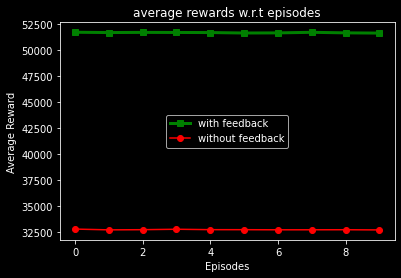

In [28]:
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.plot(with_feedback_avg_rewards,'g',linewidth=3, marker='s')
plt.plot(without_feedback_avg_rewards,'r',linewidth=1.5, marker = 'o')
plt.plot()
plt.legend(["with feedback", "without feedback"], loc ="center")
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('average rewards w.r.t episodes')
plt.style.use('dark_background')
plt.show()